In [1]:
%load_ext autoreload
%autoreload 2

from hmm_alignment import *
from Bio import SeqIO
import random
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
import csv

ref = "GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGCATACGATGGAGTCGACTACAGTCGCTACGACGATGGAGTCGCGAGCGCTATGAGCGACTATGGAGTCGATACGATACGCGCACGCTATGGAGTCGAGAGCGCGCTCGTCGACTATGGAGTCGCGACTGTACGCACACGCGATGGAGTCGATAGTATGCGTACACGCGATGGAGTCGAGTCGAGACGCTGACGATATGGAGTCGATACGTAGCACGCAGACGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC"

/homes8/jingyuan/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
data = SeqIO.parse("./data/nhej/SRR11311824/SRR11311824_trim.fastq","fastq")
counter = {}
for record in data:
    t = record.seq._data.decode()
    if t not in counter:
        counter[t] = 1
    else:
        counter[t] += 1
len(counter)

246073

In [3]:
counter_filtered = {key: value for key, value in counter.items() if value >= 2 and 
                    key.count("N")<2 and key!=ref and
                    len(key) < round(1.5 * len(ref))}
len(counter_filtered)

23513

In [8]:
top_500_sequences = dict(sorted(counter_filtered.items(), key=lambda x: x[1], reverse=True)[:500])
top_500_sequences

{'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 150788,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 42090,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGAATATGGAGTCGATACGTAGCACGCAGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 22394,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATACGTAGCACGCAGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 16892,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGAAGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 9582,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 8968,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGCGATGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 8523,
 'GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGATGGAGTCGAGTCGAGTCCAGACGCTGGAGTCGATACGTAGCACGCAGAGGGAGCTAGAATTCTAACTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGC': 7611,
 'GAGCTGTACAAGTAAGCGGC

In [9]:
top_sequences = [key for key, value in top_500_sequences.items() for _ in range(value)]
len(top_sequences)

899356

In [10]:
import crispr_hmm

model = crispr_hmm.hmm_model(ref)
model.estimate_param(top_sequences,ncores=5)

Text(0, 0.5, 'delta')

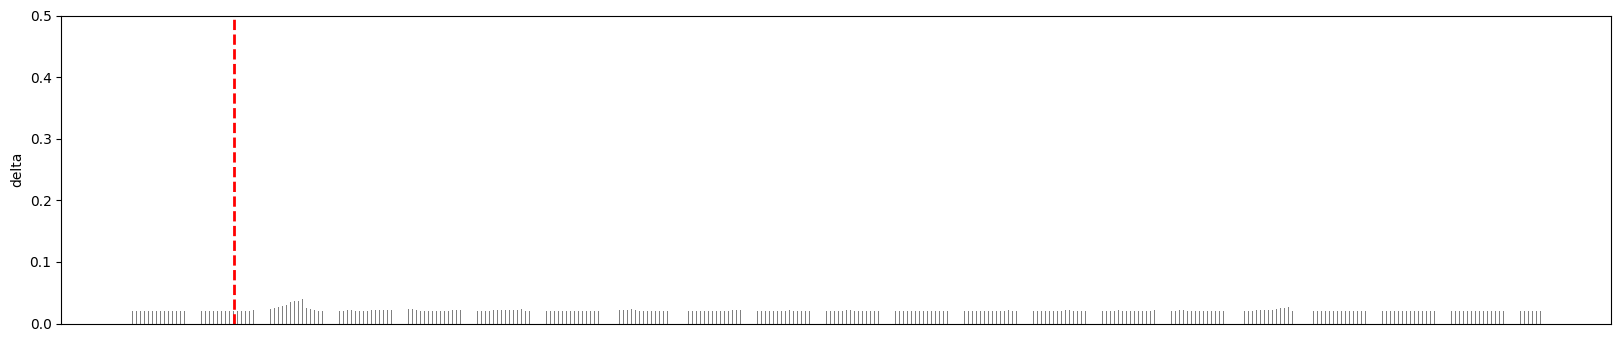

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
param = "delta"
pos = [j for j in range(model.n+1)]
ax.bar(pos, getattr(model,param),width=0.2,color="gray")

ax.axvline(x=25, color='red', linestyle='--', linewidth=2)
ax.set_xticks([])
ax.set_ylim((0, 0.5)) 
ax.set_ylabel("%s"%param,fontsize=10)

In [ ]:
filtered_reads = [key for key, value in counter_filtered.items() for _ in range(value)]

NW_result = []
random.seed(10)
for t in filtered_reads:
    align = pairwise2.align.globalms(ref,
                    t,
                    2,
                    -2,
                    -6,
                    -0.1,
                    penalize_end_gaps=1)
    random_alignment = random.sample(align,1)
    NW_result.append(random_alignment[0][:3])
    
with open("./output/NW_carlin_result.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["aligned_ref","aligned_read","score"])
    for row in NW_result:
        writer.writerow(row)

In [ ]:
HMM_result = []

for r in model.viterbi(filtered_reads,ncores=10):
    HMM_result.append(r)

with open("./output/HMM_carlin_result.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["aligned_ref","aligned_read","score"])
    for row in HMM_result:
        writer.writerow(row)